In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx

from opt_utils import *
from linalg_utils import *

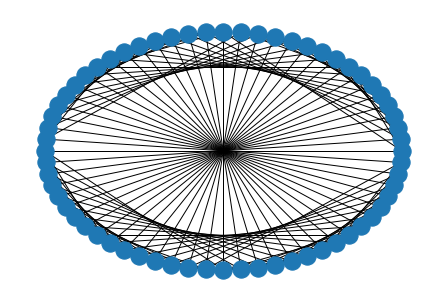

In [2]:
graph_file = "hamming6-2.mtx"
graph_type = 1

G = nx.complement(load_graph(graph_file, graph_type))
n = len(G)
nx.draw(G, nx.circular_layout(G))


## Lovasz

In [ ]:
prob_lovasz, Z = lovasz_sdp(G)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 18 11:34:09 AM: Your problem has 40000 variables, 5971 constraints, and 40000 parameters.
(CVXPY) Aug 18 11:34:09 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 18 11:34:09 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 18 11:34:09 AM: Compiling problem (target solver=SCS).
(CVXPY) Aug 18 11:34:09 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Aug 18 11:34:09 AM: Applying reduction FlipObjective
(CVXPY) Aug 18 11:34:09 AM: Applying red

F:\miniconda3\envs\sdp\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:187: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


(CVXPY) Aug 18 11:34:10 AM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 18 11:34:10 AM: Applying reduction ConeMatrixStuffing


In [ ]:
Z_val = remove_small_eigenvalues(Z.value)

In [ ]:
Z_center = 1 / n * np.eye(n)

### Fixed point iteration

In [ ]:
# fixed_point_iteration(prob_lovasz, Z, -Z_center)
#
# Z_fixed_point = Z.value
# Z.value = Z_val

In [ ]:
# try:
#     Z_vec = recover_incidence_vector(Z_fixed_point, "lovasz")
#     nx.draw(G, nx.circular_layout(G), node_color=Z_vec)
# except:
#     print("recovery failed")

## Grotschel

In [ ]:
prob_grotschel, X, x, X_plus = grotschel_sdp(G)

In [ ]:
X_val = remove_small_eigenvalues(X.value)
x_val = x.value

In [ ]:
find_center_point(prob_grotschel, X_plus)

X_center = X.value
# X_center = X_plus.value

X.value = X_val
x.value = x_val

### Fixed point iteration

In [ ]:
fixed_point_iteration(prob_grotschel, X, -X_center)
# fixed_point_iteration(prob_grotschel, X_plus, -X_center)

X_fixed_point = X.value
X_plus_fixed_point = X_plus.value
X.value = X_val
x.value = x_val

In [ ]:
try:
    X_vec = recover_incidence_vector(X_fixed_point, "grotschel")
    nx.draw(G, nx.circular_layout(G), node_color=X_vec)
except:
    print("recovery failed")

## Benson & Ye

In [ ]:
prob_benson, V = benson_sdp(G)

In [ ]:
V_val = remove_small_eigenvalues(V.value)

In [ ]:
find_center_point(prob_benson, V)

V_center = V.value
V.value = V_val

### Fixed point iteration

In [ ]:
fixed_point_iteration(prob_benson, V, -V_center)
# fixed_point_iteration(prob_benson, V)

V_fixed_point = V.value
V.value = V_val

In [ ]:
try:
    V_vec = recover_incidence_vector(V_fixed_point, "benson")
    nx.draw(G, nx.circular_layout(G), node_color=V_vec)
except:
    print("recovery failed")

### Hyperplane rounding

In [18]:
benson_cost_mat = np.block([[0.5 * np.eye(n), np.array([[0.25]] * n)], [np.array([[0.25]] * n).T, 0]])
benson_cost = lambda v : np.trace(benson_cost_mat @ np.outer(v, v))

max_cost = -np.Inf
max_v = None
for i in range(100):
    v, _, v_temp = hyperplane_rounding(decompose_psd(V_val), benson_cost, n_iter=1)
    for (i,j) in G.edges:
        if np.abs(v[i] + v[j] + v[n]) != 1:
            if np.abs(v_temp[i] - v_temp[n]) > np.abs(v_temp[j] - v_temp[n]):
                v[i] = -v[i]
            else:
                v[j] = -v[j]
    current_cost = benson_cost(v)
    if current_cost > max_cost:
        max_cost = current_cost
        max_v = v

max_v *= max_v[n]
max_v = max_v[0:-1]

In [19]:
max_cost

4.0

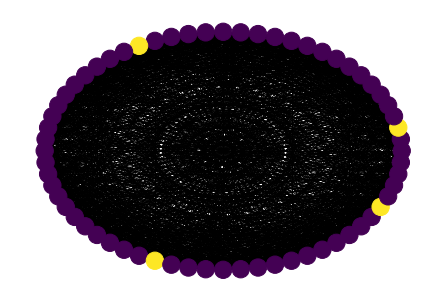

In [20]:
nx.draw(G, nx.circular_layout(G), node_color=max_v)

## Gruber & Rendl greedy algorithm

In [21]:
greedy_z = greedy_stable_set_rounding(Z_val, G)
np.sum(greedy_z)

4.0

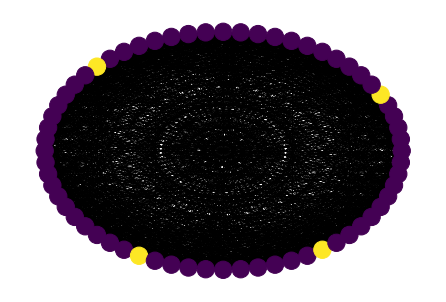

In [22]:
nx.draw(G, nx.circular_layout(G), node_color=greedy_z)

In [23]:
greedy_x = greedy_stable_set_rounding(X_val, G)
np.sum(greedy_x)

4.0

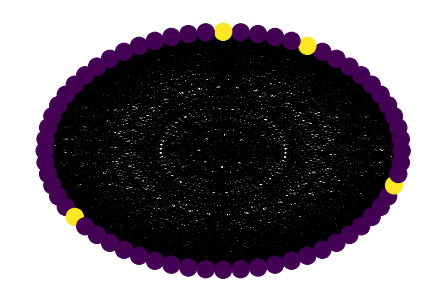

In [24]:
nx.draw(G, nx.circular_layout(G), node_color=greedy_x)

In [25]:
len(nx.maximal_independent_set(G))

4